# Image classification for identification of eye diseases using eye disease retinal image dataset.
##### Author
    Md. Mintu Hossain
    ID: 2315034650
    
    This research focusses on classifying retinal eye disease images using different deep learning architectures.
    The objective is to develop a model that can accurately identify various retinal diseases, aiding in early diagnosis treatment.

## 1. Installations & Importing Required Libraries and Packages

In [1]:
!pip install tensorflow
!pip install opencv-python
!pip3 install imagehash
!pip install matplotlib seaborn

In [2]:
import os
import time
import shutil
import pathlib
import itertools
import imagehash
from PIL import Image
# import data handling tools
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


## 2. Import Dataset

In [3]:

dataset_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/eye_dataset'

image_data = []  # To store images
labels = []      # To store corresponding labels

for class_dir in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, class_dir)):
        class_label = class_dir
        class_path = os.path.join(dataset_path, class_dir)
        for image_filename in os.listdir(class_path):
            if image_filename.endswith(".jpg") or image_filename.endswith(".jpeg"):
                image_path = os.path.join(class_path, image_filename)
                image = Image.open(image_path)
                image_data.append(image)
                labels.append(class_label)

## 3. Data Visualization

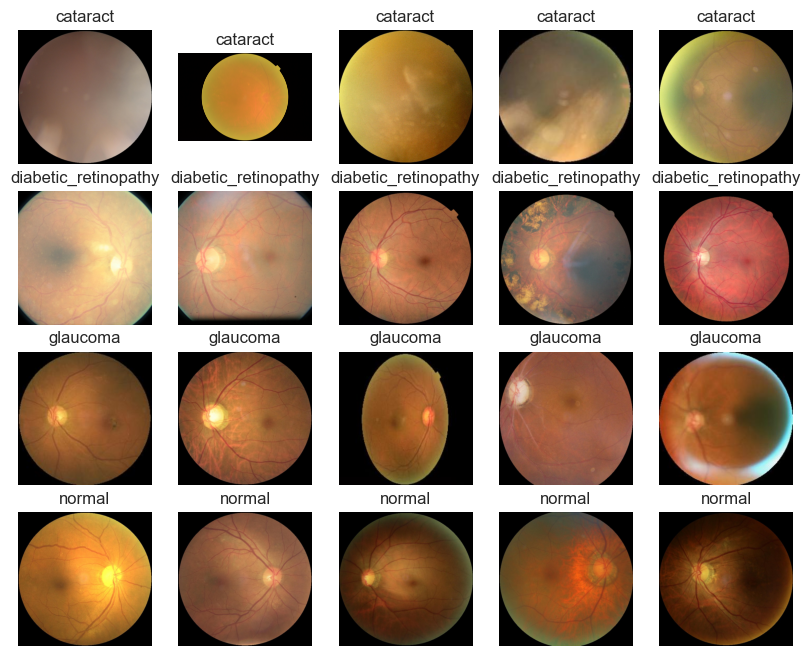

In [4]:

# Path to the directory containing your dataset
##dd = 'path_to_dataset_directory'

# List of subdirectories (representing categories or classes)
categories = sorted(os.listdir(dataset_path))

# Number of sample images to display per category
num_samples = 5

# Create a figure with subplots for each category
fig, axs = plt.subplots(len(categories), num_samples, figsize=(10, 8))

for i, category in enumerate(categories):
    category_dir = os.path.join(dataset_path, category)
    image_files = os.listdir(category_dir)
    
    # Randomly select a few sample images
    sample_images = random.sample(image_files, num_samples)
    
    for j, image_file in enumerate(sample_images):
        image_path = os.path.join(category_dir, image_file)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
        
        axs[i, j].imshow(img)
        axs[i, j].set_title(category)
        axs[i, j].axis('off')

plt.show()

## 4. Splitting

In [4]:
import random

# Set your dataset path
dataset_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/eye_dataset'

# Define paths for your training, validation, and test sets
train_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/training_data'
valid_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/validation_data'
test_path = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/testing_data'

# Define the ratio for splitting (e.g., 70% train, 15% validation, 15% test)
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# Create directories for the training, validation, and test sets
os.makedirs(train_path, exist_ok=True)
os.makedirs(valid_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Iterate through the classes in your dataset
for class_dir in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, class_dir)):
        class_images = os.listdir(os.path.join(dataset_path, class_dir))
        random.shuffle(class_images)  # Shuffle the images in each class

        # Split the images into training, validation, and test sets
        num_images = len(class_images)
        num_train = int(train_ratio * num_images)
        num_valid = int(valid_ratio * num_images)

        train_images = class_images[:num_train]
        valid_images = class_images[num_train:num_train + num_valid]
        test_images = class_images[num_train + num_valid:]

        # Copy images to the corresponding directories
        for image in train_images:
            src = os.path.join(dataset_path, class_dir, image)
            dest = os.path.join(train_path, class_dir, image)
            os.makedirs(os.path.dirname(dest), exist_ok=True)
            shutil.copy(src, dest)

        for image in valid_images:
            src = os.path.join(dataset_path, class_dir, image)
            dest = os.path.join(valid_path, class_dir, image)
            os.makedirs(os.path.dirname(dest), exist_ok=True)
            shutil.copy(src, dest)

        for image in test_images:
            src = os.path.join(dataset_path, class_dir, image)
            dest = os.path.join(test_path, class_dir, image)
            os.makedirs(os.path.dirname(dest), exist_ok=True)
            shutil.copy(src, dest)

## 5. Data Partitioning (Training & Testing)

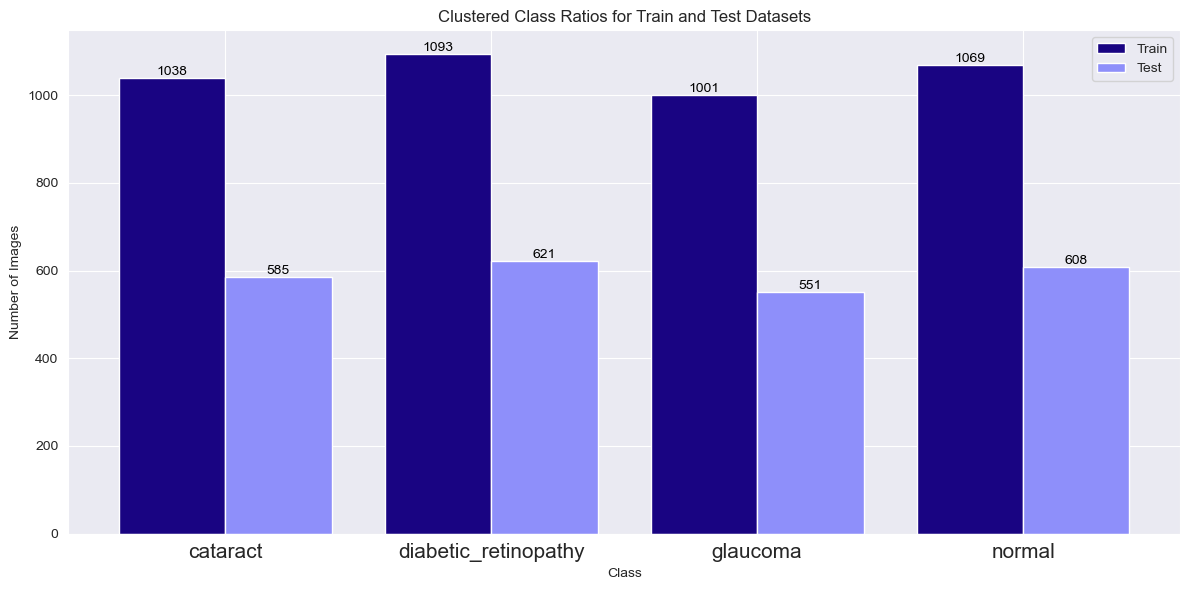

In [5]:
# Define the paths to your train and test datasets
train_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/training_data'
test_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/testing_data'

# Initialize dictionaries to store class counts for train and test
train_class_counts = {}
test_class_counts = {}

# Count the number of images for each class in the train dataset
for class_dir in os.scandir(train_dir):
    if class_dir.is_dir():
        class_name = class_dir.name
        image_count = len([entry.name for entry in os.scandir(class_dir) if entry.is_file()])
        train_class_counts[class_name] = image_count

# Count the number of images for each class in the test dataset
for class_dir in os.scandir(test_dir):
    if class_dir.is_dir():
        class_name = class_dir.name
        image_count = len([entry.name for entry in os.scandir(class_dir) if entry.is_file()])
        test_class_counts[class_name] = image_count

# Extract class names and counts for plotting
train_class_names = list(train_class_counts.keys())
train_image_counts = list(train_class_counts.values())

test_class_names = list(test_class_counts.keys())
test_image_counts = list(test_class_counts.values())

# Combine the train and test data for plotting
all_class_names = train_class_names
train_image_counts = np.array(train_image_counts)
test_image_counts = np.array(test_image_counts)

x = np.arange(len(all_class_names))
width = 0.40

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_image_counts, width, label='Train', color='#190482')
plt.bar(x + width/2, test_image_counts, width, label='Test', color='#8E8FFA')
plt.title('Clustered Class Ratios for Train and Test Datasets')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.legend()
plt.xticks(x, all_class_names, rotation=0, fontsize=15, ha="center")

# Add count labels on top of the bars
for i, count in enumerate(train_image_counts):
    plt.text(x[i] - width/2, count, str(count), ha='center', va='bottom', fontsize=10, color='black')
for i, count in enumerate(test_image_counts):
    plt.text(x[i] + width/2, count, str(count), ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

## 6. VGG16 Model

    VGG16 is a convolutional neural network(CNN) architecture known for its deep layers and simplicity, consisting of 16
    weight layers, including 13 convolutional layers and 3 fully connected layers. It was developed by the Visual Geometry
    Group at the University of Oxford and has been widely used for image classification and feature extraction tasks in
    computer vision.
    In this section, we tarin the VGG16 model.

In [6]:
train_data_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/training_data'
valid_data_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/validation_data'
batch_size = 32
image_size = (224, 224) 
num_classes = 4  

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4201 images belonging to 4 classes.
Found 2335 images belonging to 4 classes.


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained VGG model
for layer in base_model.layers:
    layer.trainable = False

In [8]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
epochs = 15  # Set the number of training epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/15
131/131 [==============================] - 1665s 13s/step - loss: 0.9999 - accuracy: 0.5754 - val_loss: 0.6806 - val_accuracy: 0.7465
Epoch 2/15
131/131 [==============================] - 1476s 11s/step - loss: 0.7189 - accuracy: 0.7057 - val_loss: 0.5370 - val_accuracy: 0.8116
Epoch 3/15
131/131 [==============================] - 1204s 9s/step - loss: 0.6430 - accuracy: 0.7378 - val_loss: 0.5328 - val_accuracy: 0.7917
Epoch 4/15
131/131 [==============================] - 1203s 9s/step - loss: 0.6011 - accuracy: 0.7573 - val_loss: 0.5183 - val_accuracy: 0.7995
Epoch 5/15
131/131 [==============================] - 1205s 9s/step - loss: 0.5871 - accuracy: 0.7714 - val_loss: 0.7629 - val_accuracy: 0.6845
Epoch 6/15
131/131 [==============================] - 1200s 9s/step - loss: 0.5675 - accuracy: 0.7726 - val_loss: 0.5409 - val_accuracy: 0.7808
Epoch 7/15
131/131 [==============================] - 1210s 9s/step - loss: 0.5402 - accuracy: 0.7860 - val_loss: 0.5403 - val_accurac

## 7. Validation Loss

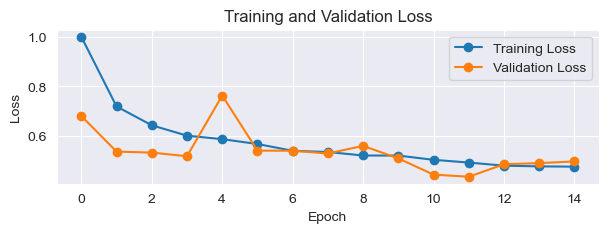

In [10]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have access to the training history
# The training history is typically returned by the `model.fit` method

# Access the training history
# history = model.fit()  # Replace with your actual model.fit() call

# Plot training and validation loss
plt.figure(figsize=(7, 2))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 8. Validation Accuracy

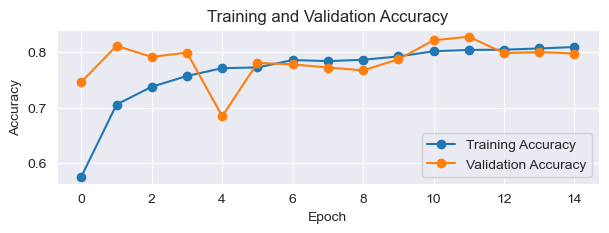

In [11]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and have access to the training history
# The training history is typically returned by the `model.fit` method

# Access the training history
#history = model.fit()  # Replace with your actual model.fit() call

# Plot training and validation accuracy
plt.figure(figsize=(7, 2))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 9. Model Performance Evaluation
     Model evaluation performance involves assessing a machine learning model's effectiveness using metrics like
    accuracy, precision, recall, F1-score, and ROC AUC. This process helps gauge the model's suitability for 
    real-world applications and guides improvements.

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you have already trained your VGG model and you have the test data in a directory
test_data_dir = 'C:/Users/USER/Desktop/Artificial_Intelligence/Image_Processing/VGG_Inception/testing_data'
batch_size = 32  # Adjust the batch size as needed

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),  # Adjust to match your model's input size
    batch_size=batch_size,
    class_mode='categorical',  # Change if using different class modes
    shuffle=False  # Set to False to maintain order for confusion matrix
)

# Make predictions on the test data
predictions = model.predict(test_generator)

# Convert one-hot encoded labels to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Accuracy: {accuracy:.2f}')

# Generate a classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Generate a confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(confusion)

Found 2365 images belonging to 4 classes.
74/74 [==============================] - 432s 6s/step
Accuracy: 0.80
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.94      0.77      0.85       585
diabetic_retinopathy       0.98      0.81      0.89       621
            glaucoma       0.74      0.66      0.70       551
              normal       0.65      0.94      0.77       608

            accuracy                           0.80      2365
           macro avg       0.83      0.80      0.80      2365
        weighted avg       0.83      0.80      0.80      2365

Confusion Matrix:
[[453   3  68  61]
 [  0 505  38  78]
 [ 18   5 364 164]
 [ 10   2  24 572]]


## 10. Confusion Matrix

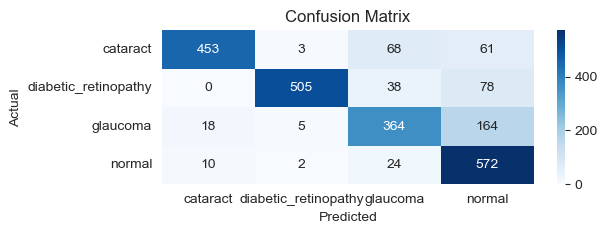

In [13]:
plt.figure(figsize=(6, 2))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 11. ROC Curve

ROC AUC score: 0.957493038452771


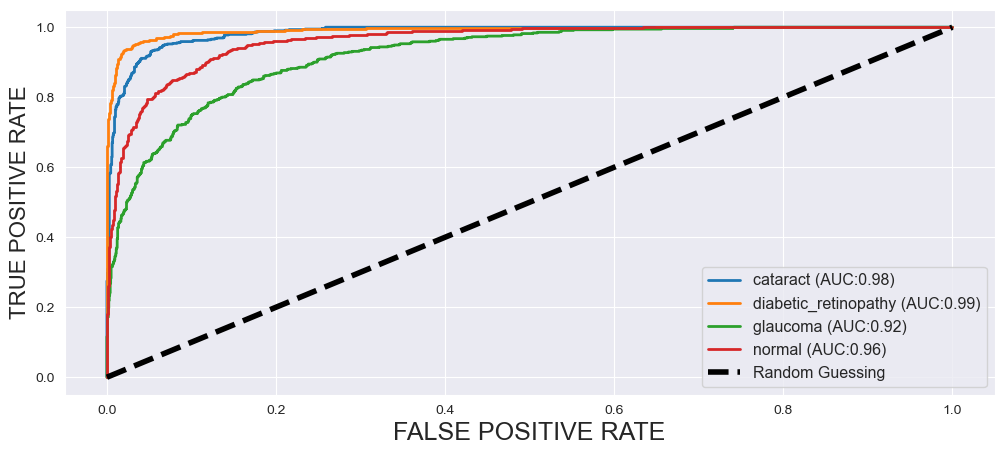

In [14]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# preds = model.predict(test_generator)
preds = predictions
# y_test = test_generator.classes
y_test = true_classes
fig, c_ax = plt.subplots(1,1, figsize = (12,5))
class_names = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()